# Our model

In [2]:
import zipfile
import os

# 定义路径
zip_file_path = 'landslide.zip'
extract_to_path = 'landslide'

# 创建解压路径，如果不存在的话
os.makedirs(extract_to_path, exist_ok=True)

# 打开zip文件
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 解压所有文件到指定路径
    zip_ref.extractall(extract_to_path)

print(f'Files have been extracted to {extract_to_path}')


Files have been extracted to landslide


/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 109s 133ms/step - loss: 1.6610 - seg_output_loss: 1.4046 - edge_output_loss: 0.2563 - seg_output_accuracy: 0.8910 - edge_output_accuracy: 0.8917 - val_loss: 1.5127 - val_seg_output_loss: 1.2856 - val_edge_output_loss: 0.2270 - val_seg_output_accuracy: 0.8941 - val_edge_output_accuracy: 0.8974
Epoch 2/100
759/759 [==============================] - 98s 130ms/step - loss: 1.5063 - seg_output_loss: 1.2852 - edge_output_loss: 0.2211 - seg_output_accuracy: 0.8963 - edge_output_accuracy: 0.8993 - val_loss: 1.4606 - val_seg_output_loss: 1.2425 - val_edge_output_loss: 0.2181 - val_seg_output_accuracy: 0.8999 - val_edge_output_accuracy: 0.9027
Epoch 3/100
759/759 [==============================] - 99s 130ms/step - loss: 1.4697 - seg_output_loss: 1.2538 - edge_output_loss: 0.2159 - seg_output_accuracy: 0.8988 - edge_output_accuracy: 0.9010 - val_loss: 1.4429 - val_seg_output_loss: 1.2252 - val_edge_output_loss: 0.2177 - val_seg_output_accurac

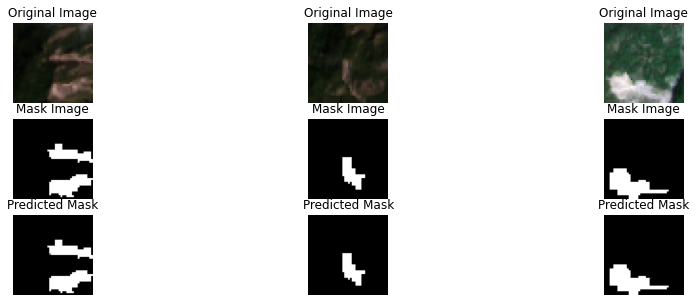

136/136 [==============================] - 28s 206ms/step
IoU: 0.8217134151671313
Dice coefficient: 0.9021314937053688
Accuracy: 0.9686331191534597
Precision: 0.9067806909119132
Recall: 0.8975316683883853
F1 Score: 0.902132474104599
Overall Accuracy (OA): 14.456829047296518
Kappa coefficient: 0.8834566991699131


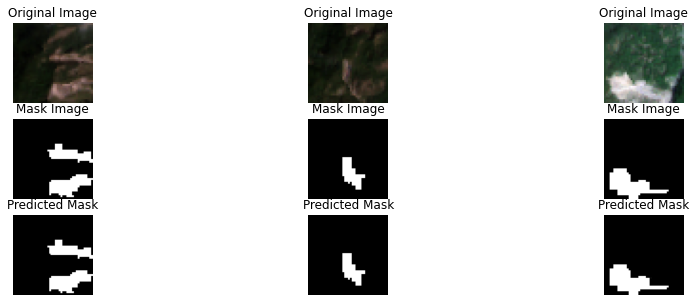

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, LayerNormalization, Dense, MultiHeadAttention, GlobalAveragePooling2D, Add, Reshape, Conv2DTranspose, Activation, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def transformer_block(inputs, num_heads, key_dim):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    ffn_output = tf.keras.Sequential([
        Dense(4 * key_dim, activation='relu'),
        Dense(inputs.shape[-1]),  # 保持与输入的最后一个维度一致
    ])(x)
    x = Add()([x, ffn_output])
    return x

def cbam_block(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    # Channel Attention Module
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    cbam_feature = tf.keras.layers.multiply([input_tensor, cbam_feature])
    
    # Spatial Attention Module
    avg_pool = tf.reduce_mean(cbam_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=3, keepdims=True)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool], axis=3)
    cbam_feature = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    
    cbam_feature = tf.keras.layers.multiply([cbam_feature, input_tensor])
    return cbam_feature

# 新增边界增强损失函数
def boundary_loss(y_true, y_pred):
    # 计算边界增强损失
    boundary_true = tf.image.sobel_edges(y_true)
    boundary_pred = tf.image.sobel_edges(y_pred)
    boundary_loss = tf.reduce_mean(tf.square(boundary_true - boundary_pred))
    return boundary_loss

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def unetplusplus_transformer_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1_1)
    conv1_1 = cbam_block(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2_1)
    conv2_1 = cbam_block(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3_1)
    conv3_1 = cbam_block(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4_1)
    conv4_1 = cbam_block(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5_1)
    conv5_1 = cbam_block(conv5_1)

    # Decoder
    up4_1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_1 = concatenate([up4_1, conv4_1], axis=3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(up4_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)
    conv4_1 = cbam_block(conv4_1)

    up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
    up3_1 = concatenate([up3_1, conv3_1], axis=3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(up3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    conv3_1 = cbam_block(conv3_1)

    up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_1)
    up2_1 = concatenate([up2_1, conv2_1], axis=3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(up2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    conv2_1 = cbam_block(conv2_1)

    up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_1)
    up1_1 = concatenate([up1_1, conv1_1], axis=3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(up1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    conv1_1 = cbam_block(conv1_1)

    # Second Level Nested Skip Connections
    up4_2 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(up4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_2)
    conv4_2 = cbam_block(conv4_2)

    up3_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(up3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_2)
    conv3_2 = cbam_block(conv3_2)

    up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_2)
    up2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(up2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_2)
    conv2_2 = cbam_block(conv2_2)

    up1_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
    up1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(up1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_2)
    conv1_2 = cbam_block(conv1_2)

    # Third Level Nested Skip Connections
    up3_3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_3 = concatenate([up3_3, conv3_2, conv3_1], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(up3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)
    conv3_3 = cbam_block(conv3_3)

    up2_3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_3)
    up2_3 = concatenate([up2_3, conv2_2, conv2_1], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(up2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)
    conv2_3 = cbam_block(conv2_3)

    up1_3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_3)
    up1_3 = concatenate([up1_3, conv1_2, conv1_1], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(up1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    conv1_3 = cbam_block(conv1_3)

    # Transformer Block
    transformer_input = Reshape((conv5_1.shape[1] * conv5_1.shape[2], conv5_1.shape[3]))(conv5_1)
    transformer_output = transformer_block(transformer_input, num_heads=8, key_dim=128)
    transformer_output = Reshape((conv5_1.shape[1], conv5_1.shape[2], conv5_1.shape[3]))(transformer_output)

    # Segmentation Output
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='seg_output')(conv1_3)
    
    # Edge Detection Head
    edge_head = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    edge_head = Conv2D(1, 1, activation='sigmoid', name='edge_output')(edge_head)

    model = Model(inputs=inputs, outputs=[segmentation_output, edge_head])

    # 修改损失函数为复合损失函数
    def composite_loss(y_true, y_pred):
        cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        iou_loss = 1 - iou_coefficient(y_true, y_pred)
        return cross_entropy_loss + dice_loss + iou_loss

    # 结合边界增强损失
    combined_loss = lambda y_true, y_pred: composite_loss(y_true, y_pred) + boundary_loss(y_true, y_pred)

    model.compile(optimizer=Adam(lr=1e-4), 
                  loss={'seg_output': combined_loss, 'edge_output': 'binary_crossentropy'}, 
                  metrics={'seg_output': ['accuracy'], 'edge_output': ['accuracy']})
    return model

def apply_crf(image, prediction):
    # 将预测结果转换为概率分布
    prediction = prediction.squeeze()  # 将 (256, 256, 1) 转换为 (256, 256)
    softmax = np.zeros((2, prediction.shape[0], prediction.shape[1]), dtype=np.float32)
    softmax[0, :, :] = 1 - prediction
    softmax[1, :, :] = prediction

    # 创建CRF模型
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], 2)

    # 将unary能量添加到CRF模型中
    unary = unary_from_softmax(softmax)
    d.setUnaryEnergy(unary)

    # 增加对比度和位置的一对一对特征
    feats = create_pairwise_gaussian(sdims=(3, 3), shape=image.shape[:2])
    d.addPairwiseEnergy(feats, compat=3)

    # 增加颜色特征
    feats = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=image, chdim=2)
    d.addPairwiseEnergy(feats, compat=10)

    # 执行推理
    Q = d.inference(5)

    # 获得最终分割结果
    map = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

    return map

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    seg_preds = preds[0]
    edge_preds = preds[1]
    seg_preds_binary = (seg_preds > 0.5).astype(np.float32)

    # 应用CRF后处理
    crf_preds = np.zeros(seg_preds_binary.shape[:3], dtype=np.float32)
    for i in range(images.shape[0]):
        crf_preds[i] = apply_crf(images[i].astype(np.uint8), seg_preds_binary[i])

    # 确保 masks 和 crf_preds 的形状匹配
    masks = masks.squeeze()  # 将 (770, 256, 256, 1) 转换为 (770, 256, 256)

    # 计算评估指标
    intersection = np.logical_and(masks, crf_preds)
    union = np.logical_or(masks, crf_preds)
    iou = np.sum(intersection) / np.sum(union)

    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(crf_preds))

    accuracy = accuracy_score(masks.flatten(), crf_preds.flatten())

    precision = precision_score(masks.flatten(), crf_preds.flatten())

    recall = recall_score(masks.flatten(), crf_preds.flatten())

    f1 = f1_score(masks.flatten(), crf_preds.flatten())

    oa = (intersection.sum() / masks.size) * 100

    kappa = cohen_kappa_score(masks.flatten(), crf_preds.flatten())

    return iou, dice, accuracy, precision, recall, f1, oa, kappa, crf_preds, edge_preds

# 加载数据
data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNet++-Transformer多任务模型
input_shape = (256, 256, 3)
multitask_model = unetplusplus_transformer_model(input_shape)

# 训练模型
multitask_model.fit(images, {'seg_output': masks, 'edge_output': masks}, batch_size=4, epochs=100, validation_split=0.3)

# 可视化结果
predictions = multitask_model.predict(images)
plot_images(images, masks, predictions[0])

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, crf_preds, edge_preds = compute_metrics(multitask_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)

# 可视化结果
plot_images(images, masks, crf_preds)


In [3]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-dhjiixo6
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-dhjiixo6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp38-cp38-linux_x86_64.whl size=3828324 sha256=872f1cf83df43395e028d5675bd1a0c0ded7c7c32c294f5e828b27b5e6d31856
  Stored in directory: /tmp/pip-ephem-wheel-cache-ggqrydwe/wheels/45/56/7a/826b4f5cd8459926ff5996ba9994fc36672487b6d2fa50d3d4
Successfully built pydensecrf


/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 107s 131ms/step - loss: 1.6791 - seg_output_loss: 1.4211 - edge_output_loss: 0.2580 - seg_output_accuracy: 0.8892 - edge_output_accuracy: 0.8904 - val_loss: 1.6014 - val_seg_output_loss: 1.3621 - val_edge_output_loss: 0.2393 - val_seg_output_accuracy: 0.8939 - val_edge_output_accuracy: 0.8908
Epoch 2/100
759/759 [==============================] - 98s 130ms/step - loss: 1.4964 - seg_output_loss: 1.2778 - edge_output_loss: 0.2186 - seg_output_accuracy: 0.8974 - edge_output_accuracy: 0.9001 - val_loss: 1.4908 - val_seg_output_loss: 1.2664 - val_edge_output_loss: 0.2244 - val_seg_output_accuracy: 0.8894 - val_edge_output_accuracy: 0.8954
Epoch 3/100
759/759 [==============================] - 98s 129ms/step - loss: 1.4630 - seg_output_loss: 1.2495 - edge_output_loss: 0.2135 - seg_output_accuracy: 0.8993 - edge_output_accuracy: 0.9015 - val_loss: 1.4945 - val_seg_output_loss: 1.2657 - val_edge_output_loss: 0.2288 - val_seg_output_accurac

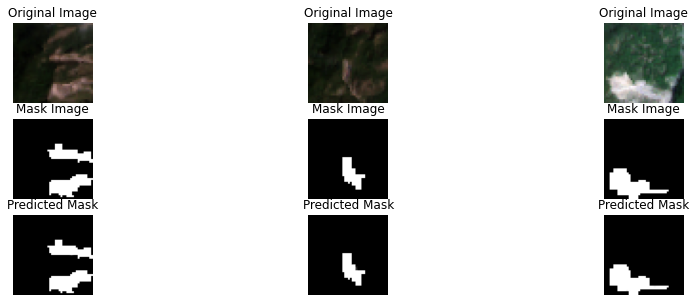

136/136 [==============================] - 28s 205ms/step
IoU: 0.8090016721421621
Dice coefficient: 0.8944169097392484
Accuracy: 0.9670312805386878
Precision: 0.9236726821892322
Recall: 0.8669592183125101
F1 Score: 0.8944178268051772
Overall Accuracy (OA): 1.3964388836136552
Kappa coefficient: 0.8749068432050926


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, LayerNormalization, Dense, MultiHeadAttention, GlobalAveragePooling2D, Add, Reshape, Conv2DTranspose, Activation, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def transformer_block(inputs, num_heads, key_dim):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    ffn_output = tf.keras.Sequential([
        Dense(4 * key_dim, activation='relu'),
        Dense(inputs.shape[-1]),  # 保持与输入的最后一个维度一致
    ])(x)
    x = Add()([x, ffn_output])
    return x

def cbam_block(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    # Channel Attention Module
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    cbam_feature = tf.keras.layers.multiply([input_tensor, cbam_feature])
    
    # Spatial Attention Module
    avg_pool = tf.reduce_mean(cbam_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=3, keepdims=True)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool], axis=3)
    cbam_feature = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    
    cbam_feature = tf.keras.layers.multiply([cbam_feature, input_tensor])
    return cbam_feature

# 新增边界增强损失函数
def boundary_loss(y_true, y_pred):
    # 计算边界增强损失
    boundary_true = tf.image.sobel_edges(y_true)
    boundary_pred = tf.image.sobel_edges(y_pred)
    boundary_loss = tf.reduce_mean(tf.square(boundary_true - boundary_pred))
    return boundary_loss

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def unetplusplus_transformer_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1_1)
    conv1_1 = cbam_block(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2_1)
    conv2_1 = cbam_block(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3_1)
    conv3_1 = cbam_block(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4_1)
    conv4_1 = cbam_block(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5_1)
    conv5_1 = cbam_block(conv5_1)

    # Decoder
    up4_1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_1 = concatenate([up4_1, conv4_1], axis=3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(up4_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)
    conv4_1 = cbam_block(conv4_1)

    up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
    up3_1 = concatenate([up3_1, conv3_1], axis=3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(up3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    conv3_1 = cbam_block(conv3_1)

    up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_1)
    up2_1 = concatenate([up2_1, conv2_1], axis=3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(up2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    conv2_1 = cbam_block(conv2_1)

    up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_1)
    up1_1 = concatenate([up1_1, conv1_1], axis=3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(up1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    conv1_1 = cbam_block(conv1_1)

    # Second Level Nested Skip Connections
    up4_2 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(up4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_2)
    conv4_2 = cbam_block(conv4_2)

    up3_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(up3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_2)
    conv3_2 = cbam_block(conv3_2)

    up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_2)
    up2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(up2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_2)
    conv2_2 = cbam_block(conv2_2)

    up1_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
    up1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(up1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_2)
    conv1_2 = cbam_block(conv1_2)

    # Third Level Nested Skip Connections
    up3_3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_3 = concatenate([up3_3, conv3_2, conv3_1], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(up3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)
    conv3_3 = cbam_block(conv3_3)

    up2_3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_3)
    up2_3 = concatenate([up2_3, conv2_2, conv2_1], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(up2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)
    conv2_3 = cbam_block(conv2_3)

    up1_3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_3)
    up1_3 = concatenate([up1_3, conv1_2, conv1_1], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(up1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    conv1_3 = cbam_block(conv1_3)

    # Transformer Block
    transformer_input = Reshape((conv5_1.shape[1] * conv5_1.shape[2], conv5_1.shape[3]))(conv5_1)
    transformer_output = transformer_block(transformer_input, num_heads=8, key_dim=128)
    transformer_output = Reshape((conv5_1.shape[1], conv5_1.shape[2], conv5_1.shape[3]))(transformer_output)

    # Segmentation Output
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='seg_output')(conv1_3)
    
    # Edge Detection Head
    edge_head = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    edge_head = Conv2D(1, 1, activation='sigmoid', name='edge_output')(edge_head)

    model = Model(inputs=inputs, outputs=[segmentation_output, edge_head])

    # 修改损失函数为复合损失函数
    def composite_loss(y_true, y_pred):
        cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        iou_loss = 1 - iou_coefficient(y_true, y_pred)
        return cross_entropy_loss + dice_loss + iou_loss

    # 结合边界增强损失
    combined_loss = lambda y_true, y_pred: composite_loss(y_true, y_pred) + boundary_loss(y_true, y_pred)

    model.compile(optimizer=Adam(lr=1e-4), 
                  loss={'seg_output': combined_loss, 'edge_output': 'binary_crossentropy'}, 
                  metrics={'seg_output': ['accuracy'], 'edge_output': ['accuracy']})
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    seg_preds = preds[0]
    edge_preds = preds[1]
    seg_preds_binary = (seg_preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, seg_preds_binary)
    union = np.logical_or(masks, seg_preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(seg_preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), seg_preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, seg_preds_binary, edge_preds

# 加载数据
data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNet++-Transformer多任务模型
input_shape = (256, 256, 3)
multitask_model = unetplusplus_transformer_model(input_shape)

# 训练模型
multitask_model.fit(images, {'seg_output': masks, 'edge_output': masks}, batch_size=4, epochs=100, validation_split=0.3)

# 可视化结果
predictions = multitask_model.predict(images)
plot_images(images, masks, predictions[0])

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, seg_preds_binary, edge_preds = compute_metrics(multitask_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# UNet

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score


def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)


def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的UNet模型
unet_input = Input(shape=input_shape, name='unet_input')
unet_output = unet_model(input_shape)(unet_input)

combined_output = unet_output
combined_model = Model(inputs=unet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, refined_predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


2024-05-16 16:49:11.271831: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 16:49:21.709990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 16:49:22.231914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:1f:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.p

Epoch 1/100


2024-05-16 16:49:27.114984: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-16 16:49:27.731242: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-16 16:49:27.731258: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-16 16:49:27.731340: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


759/759 [==============================] - 44s 53ms/step - loss: 0.3119 - accuracy: 0.8883 - val_loss: 0.2738 - val_accuracy: 0.8919
Epoch 2/100
759/759 [==============================] - 38s 51ms/step - loss: 0.2603 - accuracy: 0.8981 - val_loss: 0.2723 - val_accuracy: 0.8897
Epoch 3/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2530 - accuracy: 0.8990 - val_loss: 0.2534 - val_accuracy: 0.8977
Epoch 4/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2424 - accuracy: 0.9012 - val_loss: 0.2537 - val_accuracy: 0.8950
Epoch 5/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2396 - accuracy: 0.9011 - val_loss: 0.2477 - val_accuracy: 0.8978
Epoch 6/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2336 - accuracy: 0.9025 - val_loss: 0.2406 - val_accuracy: 0.8994
Epoch 7/100
759/759 [==============================] - 39s 51ms/step - loss: 0.2280 - accuracy: 0.9038 - val_loss: 0.2450 - val_accuracy: 0.89

NameError: name 'refined_predictions' is not defined

136/136 [==============================] - 15s 106ms/step


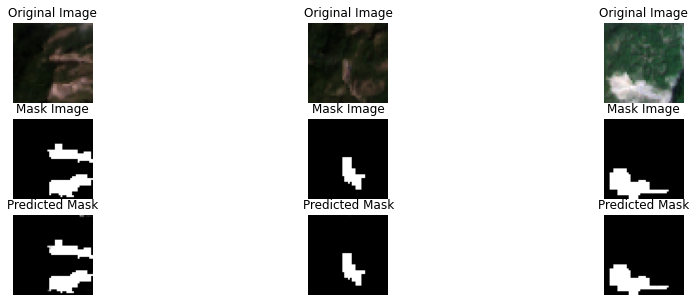

136/136 [==============================] - 15s 107ms/step
IoU: 0.8197449666039985
Dice coefficient: 0.900944141396977
Accuracy: 0.967809299348493
Precision: 0.8931633588319127
Recall: 0.9088632083151693
F1 Score: 0.9009448924414981
Overall Accuracy (OA): 1.4639349777577026
Kappa coefficient: 0.8817285613288518


In [3]:

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# FCN

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 34s 42ms/step - loss: 0.3014 - accuracy: 0.8882 - val_loss: 0.2636 - val_accuracy: 0.8905
Epoch 2/100
759/759 [==============================] - 30s 40ms/step - loss: 0.2531 - accuracy: 0.8979 - val_loss: 0.2562 - val_accuracy: 0.8914
Epoch 3/100
759/759 [==============================] - 31s 41ms/step - loss: 0.2431 - accuracy: 0.8998 - val_loss: 0.2488 - val_accuracy: 0.8961
Epoch 4/100
759/759 [==============================] - 30s 40ms/step - loss: 0.2379 - accuracy: 0.9001 - val_loss: 0.2421 - val_accuracy: 0.8991
Epoch 5/100
759/759 [==============================] - 30s 40ms/step - loss: 0.2336 - accuracy: 0.9027 - val_loss: 0.2434 - val_accuracy: 0.8982
Epoch 6/100
759/759 [==============================] - 30s 40ms/step - loss: 0.2312 - accuracy: 0.9025 - val_loss: 0.2433 - val_accuracy: 0.8957
Epoch 7/100
759/759 [==============================] - 30s 40ms/step - loss: 0.2256 - accuracy: 0.9043 - val_loss: 0.2366 - val_ac

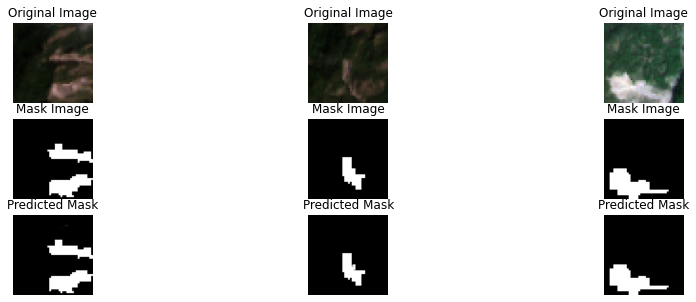

136/136 [==============================] - 11s 78ms/step
IoU: 0.8241051452861291
Dice coefficient: 0.9035722317998518
Accuracy: 0.968841024992074
Precision: 0.9008244340767533
Recall: 0.9063363293873234
F1 Score: 0.9035719760078413
Overall Accuracy (OA): 1.4598648532184004
Kappa coefficient: 0.8849905323401336


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def fcn_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 使用修改后的FCN模型
fcn_input = Input(shape=input_shape, name='fcn_input')
fcn_output = fcn_model(input_shape)(fcn_input)

combined_output = fcn_output
combined_model = Model(inputs=fcn_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)


predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# Segnet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 41s 51ms/step - loss: 0.4338 - accuracy: 0.8828 - val_loss: 0.3582 - val_accuracy: 0.8899
Epoch 2/100
759/759 [==============================] - 38s 49ms/step - loss: 0.3131 - accuracy: 0.8991 - val_loss: 0.3355 - val_accuracy: 0.8954
Epoch 3/100
759/759 [==============================] - 38s 49ms/step - loss: 0.2608 - accuracy: 0.9030 - val_loss: 0.2652 - val_accuracy: 0.8972
Epoch 4/100
759/759 [==============================] - 37s 49ms/step - loss: 0.2421 - accuracy: 0.9036 - val_loss: 0.2618 - val_accuracy: 0.8929
Epoch 5/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2307 - accuracy: 0.9058 - val_loss: 0.2508 - val_accuracy: 0.8939
Epoch 6/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2266 - accuracy: 0.9063 - val_loss: 0.2427 - val_accuracy: 0.8985
Epoch 7/100
759/759 [==============================] - 37s 49ms/step - loss: 0.2219 - accuracy: 0.9074 - val_loss: 0.2368 - val_ac

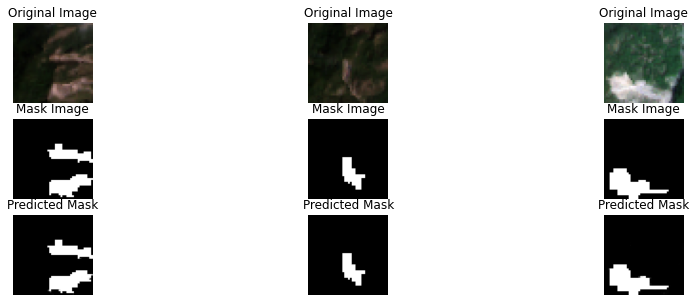

136/136 [==============================] - 13s 88ms/step
IoU: 0.8231105812353233
Dice coefficient: 0.9029731732504722
Accuracy: 0.9685679007599038
Precision: 0.8979608865649731
Recall: 0.9080430784530106
F1 Score: 0.9029738401030957
Overall Accuracy (OA): 1.462613968412695
Kappa coefficient: 0.8842208064407823


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def segnet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1, mask1 = MaxPooling2D(pool_size=(2, 2))(conv1), conv1
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2, mask2 = MaxPooling2D(pool_size=(2, 2))(conv2), conv2
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3, mask3 = MaxPooling2D(pool_size=(2, 2))(conv3), conv3
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4, mask4 = MaxPooling2D(pool_size=(2, 2))(conv4), conv4

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Concatenate()([mask4, conv5])

    up6 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Concatenate()([mask3, conv6])

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Concatenate()([mask2, conv7])

    up8 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Concatenate()([mask1, conv8])

    outputs = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 使用修改后的SegNet模型
segnet_input = Input(shape=input_shape, name='segnet_input')
segnet_output = segnet_model(input_shape)(segnet_input)

combined_output = segnet_output
combined_model = Model(inputs=segnet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# linknet

2024-05-17 12:00:50.908027: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 12:01:01.206109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 12:01:01.699435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:1f:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.p

Epoch 1/100


2024-05-17 12:01:07.161155: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-17 12:01:07.836760: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-17 12:01:07.836777: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-17 12:01:07.836831: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


759/759 [==============================] - 45s 53ms/step - loss: 0.4000 - accuracy: 0.8830 - val_loss: 1.3553 - val_accuracy: 0.8859
Epoch 2/100
759/759 [==============================] - 39s 51ms/step - loss: 0.3021 - accuracy: 0.8974 - val_loss: 0.2986 - val_accuracy: 0.8854
Epoch 3/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2520 - accuracy: 0.9003 - val_loss: 0.2487 - val_accuracy: 0.8897
Epoch 4/100
759/759 [==============================] - 39s 51ms/step - loss: 0.2262 - accuracy: 0.9035 - val_loss: 0.2448 - val_accuracy: 0.8942
Epoch 5/100
759/759 [==============================] - 39s 52ms/step - loss: 0.2147 - accuracy: 0.9053 - val_loss: 0.2450 - val_accuracy: 0.8915
Epoch 6/100
759/759 [==============================] - 39s 52ms/step - loss: 0.2124 - accuracy: 0.9047 - val_loss: 0.2563 - val_accuracy: 0.8914
Epoch 7/100
759/759 [==============================] - 39s 51ms/step - loss: 0.2082 - accuracy: 0.9067 - val_loss: 0.2737 - val_accuracy: 0.87

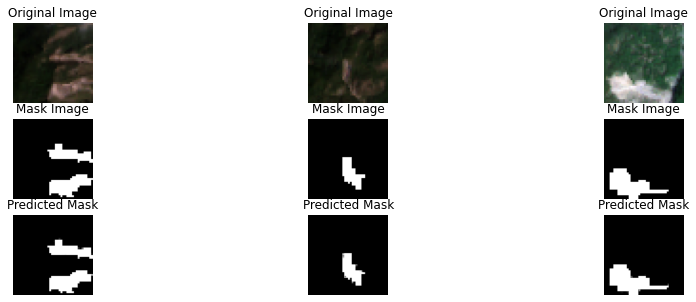

136/136 [==============================] - 13s 97ms/step
IoU: 0.8178695865406442
Dice coefficient: 0.8998104717167997
Accuracy: 0.9680531198098303
Precision: 0.9091631892212653
Recall: 0.8906493881167645
F1 Score: 0.8998110674121872
Overall Accuracy (OA): 1.4345973962348866
Kappa coefficient: 0.8808102824917738


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def linknet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(pool4)
    up5 = Conv2D(512, 2, activation='relu', padding='same')(up5)
    merge5 = Concatenate()([conv4, up5])
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(256, 2, activation='relu', padding='same')(up6)
    merge6 = Concatenate()([conv3, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 2, activation='relu', padding='same')(up7)
    merge7 = Concatenate()([conv2, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 2, activation='relu', padding='same')(up8)
    merge8 = Concatenate()([conv1, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load and prepare data
def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # Convert mask image to binary image
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

# Prepare dataset
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # Normalization
    return images, masks

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# Set data path
data_path = 'landslide4sence/TrainData_3/landslide'

# Load and prepare dataset
images, masks = prepare_dataset(data_path)

# Define input shape
input_shape = (256, 256, 3)

# Use modified LinkNet model
linknet_input = Input(shape=input_shape, name='linknet_input')
linknet_output = linknet_model(input_shape)(linknet_input)

combined_output = linknet_output
combined_model = Model(inputs=linknet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train combined model
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# Make predictions
predictions = combined_model.predict(images)

# Visualize results
plot_images(images, masks, predictions)

# Compute evaluation metrics
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# Deeplabv3

2024-05-17 15:31:20.876729: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2024-05-17 15:31:31.346035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 15:31:31.823817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:1f:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100


2024-05-17 15:31:40.065294: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-17 15:31:40.709954: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-17 15:31:40.709969: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-17 15:31:40.710018: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


759/759 [==============================] - 48s 55ms/step - loss: 0.4027 - accuracy: 0.8288 - val_loss: 0.5071 - val_accuracy: 0.8188
Epoch 2/100
759/759 [==============================] - 41s 55ms/step - loss: 0.3232 - accuracy: 0.8540 - val_loss: 0.3890 - val_accuracy: 0.8354
Epoch 3/100
759/759 [==============================] - 41s 54ms/step - loss: 0.2898 - accuracy: 0.8705 - val_loss: 0.3430 - val_accuracy: 0.8437
Epoch 4/100
759/759 [==============================] - 41s 55ms/step - loss: 0.2675 - accuracy: 0.8807 - val_loss: 0.3393 - val_accuracy: 0.8403
Epoch 5/100
759/759 [==============================] - 41s 54ms/step - loss: 0.2493 - accuracy: 0.8900 - val_loss: 0.3084 - val_accuracy: 0.8596
Epoch 6/100
759/759 [==============================] - 41s 54ms/step - loss: 0.2322 - accuracy: 0.8977 - val_loss: 0.3159 - val_accuracy: 0.8699
Epoch 7/100
759/759 [==============================] - 42s 55ms/step - loss: 0.2216 - accuracy: 0.9023 - val_loss: 0.2796 - val_accuracy: 0.87

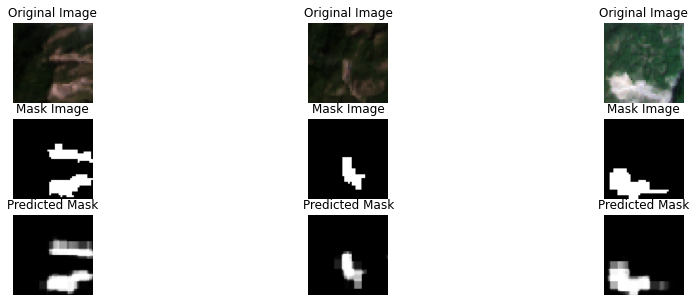

136/136 [==============================] - 5s 33ms/step
IoU: 0.6718353443476625
Dice coefficient: 0.8037097812895861
Accuracy: 0.9380768645543615
Precision: 0.8210936061530272
Recall: 0.7870470899620448
F1 Score: 0.80370994263171
Overall Accuracy (OA): 1.2677218679296605
Kappa coefficient: 0.7669696689362459


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import DepthwiseConv2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def deeplabv3_model(input_size=(256, 256, 3)):
    base_model = MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')
    
    # Encoder部分
    inputs = Input(input_size)
    x = base_model(inputs)
    
    # Decoder部分
    x = Conv2D(256, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)  # 输出掩模图像
    
    model = Model(inputs=inputs, outputs=x)
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # 计算IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # 计算Dice系数
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # 计算准确率
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # 计算精确率
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # 计算召回率
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # 计算F1分数
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # 总体准确率（OA）
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa系数
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的DeepLabv3+模型
deeplabv3_input = Input(shape=input_shape, name='deeplabv3_input')
deeplabv3_output = deeplabv3_model(input_shape)(deeplabv3_input)

combined_output = deeplabv3_output[:, :256, :256, :]  # 裁剪输出以匹配输入尺寸
combined_model = Model(inputs=deeplabv3_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# VGG16+FCN

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 33s 42ms/step - loss: 0.3146 - accuracy: 0.8563 - val_loss: 0.2950 - val_accuracy: 0.8613
Epoch 2/100
759/759 [==============================] - 31s 40ms/step - loss: 0.2852 - accuracy: 0.8683 - val_loss: 0.2878 - val_accuracy: 0.8653
Epoch 3/100
759/759 [==============================] - 31s 40ms/step - loss: 0.2796 - accuracy: 0.8722 - val_loss: 0.2918 - val_accuracy: 0.8629
Epoch 4/100
759/759 [==============================] - 30s 39ms/step - loss: 0.2743 - accuracy: 0.8753 - val_loss: 0.2907 - val_accuracy: 0.8668
Epoch 5/100
759/759 [==============================] - 30s 40ms/step - loss: 0.2717 - accuracy: 0.8759 - val_loss: 0.2813 - val_accuracy: 0.8683
Epoch 6/100
759/759 [==============================] - 30s 40ms/step - loss: 0.2687 - accuracy: 0.8778 - val_loss: 0.2857 - val_accuracy: 0.8668
Epoch 7/100
759/759 [==============================] - 30s 39ms/step - loss: 0.2656 - accuracy: 0.8793 - val_loss: 0.2861 - val_ac

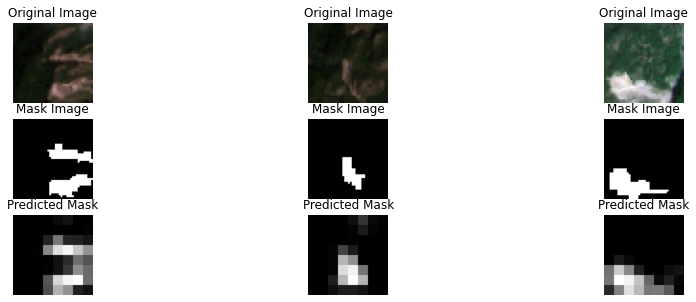

136/136 [==============================] - 6s 45ms/step
IoU: 0.5345767040420099
Dice coefficient: 0.6967088542991745
Accuracy: 0.9110162658902503
Precision: 0.7724042496528534
Recall: 0.6345257831205929
F1 Score: 0.6967090046837771
Overall Accuracy (OA): 1.0220509309880823
Kappa coefficient: 0.6451541226573536


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def vgg16_fcn(input_size=(256, 256, 3)):
    vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=input_size)

    for layer in vgg16_base.layers:
        layer.trainable = False

    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(vgg16_base.output)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    x = UpSampling2D(size=(32, 32))(x)

    model = Model(inputs=vgg16_base.input, outputs=x)
    return model

# 使用修改后的VGG16-FCN模型
input_shape = (256, 256, 3)
fcn_model = vgg16_fcn(input_shape)

fcn_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练FCN模型
fcn_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = fcn_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(fcn_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# PSPNet

2024-05-17 17:09:50.672254: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 17:10:01.363488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 17:10:01.839671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:1f:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.p

Epoch 1/100


2024-05-17 17:10:07.135116: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-17 17:10:07.788526: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-17 17:10:07.788542: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-17 17:10:07.788586: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


380/380 [==============================] - 42s 99ms/step - loss: 0.3295 - accuracy: 0.8617 - val_loss: 0.2816 - val_accuracy: 0.8941
Epoch 2/100
380/380 [==============================] - 38s 99ms/step - loss: 0.2718 - accuracy: 0.8997 - val_loss: 0.2770 - val_accuracy: 0.8944
Epoch 3/100
380/380 [==============================] - 37s 98ms/step - loss: 0.2647 - accuracy: 0.9005 - val_loss: 0.2668 - val_accuracy: 0.8978
Epoch 4/100
380/380 [==============================] - 38s 100ms/step - loss: 0.2581 - accuracy: 0.9016 - val_loss: 0.2665 - val_accuracy: 0.8978
Epoch 5/100
380/380 [==============================] - 36s 96ms/step - loss: 0.2549 - accuracy: 0.9015 - val_loss: 0.2582 - val_accuracy: 0.8986
Epoch 6/100
380/380 [==============================] - 37s 97ms/step - loss: 0.2489 - accuracy: 0.9032 - val_loss: 0.2603 - val_accuracy: 0.8974
Epoch 7/100
380/380 [==============================] - 37s 97ms/step - loss: 0.2452 - accuracy: 0.9034 - val_loss: 0.2509 - val_accuracy: 0.8

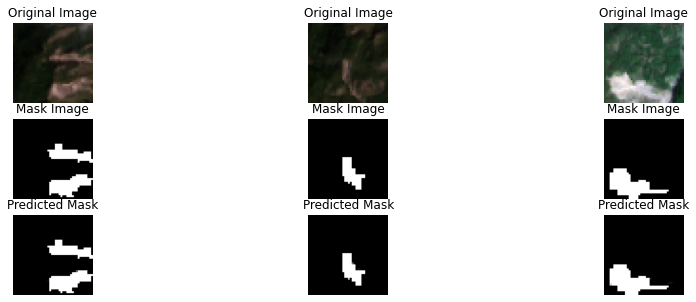

136/136 [==============================] - 14s 101ms/step
IoU: 0.8216938027785371
Dice coefficient: 0.902119457383007
Accuracy: 0.968079109359013
Precision: 0.891248026142581
Recall: 0.9132618364679359
F1 Score: 0.9021206544428588
Overall Accuracy (OA): 1.471019988514076
Kappa coefficient: 0.8830539902495063


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def pspnet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # PSPNet Model
    # Your PSPNet model architecture implementation here
    # Replace this with the architecture of PSPNet
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的PSPNet模型
pspnet_input = Input(shape=input_shape, name='pspnet_input')
pspnet_output = pspnet_model(input_shape)(pspnet_input)

combined_output = pspnet_output
combined_model = Model(inputs=pspnet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=8, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# FC-DenseNet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 27s 33ms/step - loss: 0.2537 - accuracy: 0.8908 - val_loss: 0.2372 - val_accuracy: 0.8895
Epoch 2/100
759/759 [==============================] - 24s 31ms/step - loss: 0.2198 - accuracy: 0.8989 - val_loss: 0.2301 - val_accuracy: 0.8909
Epoch 3/100
759/759 [==============================] - 24s 32ms/step - loss: 0.2168 - accuracy: 0.9003 - val_loss: 0.2327 - val_accuracy: 0.8964
Epoch 4/100
759/759 [==============================] - 23s 31ms/step - loss: 0.2132 - accuracy: 0.9016 - val_loss: 0.2218 - val_accuracy: 0.8967
Epoch 5/100
759/759 [==============================] - 24s 32ms/step - loss: 0.2105 - accuracy: 0.9024 - val_loss: 0.2235 - val_accuracy: 0.8978
Epoch 6/100
759/759 [==============================] - 23s 31ms/step - loss: 0.2085 - accuracy: 0.9028 - val_loss: 0.2199 - val_accuracy: 0.8972
Epoch 7/100
759/759 [==============================] - 23s 30ms/step - loss: 0.2088 - accuracy: 0.9034 - val_loss: 0.2191 - val_ac

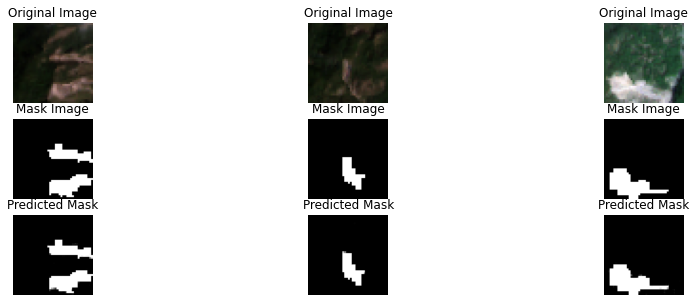

136/136 [==============================] - 10s 74ms/step
IoU: 0.8153100572224407
Dice coefficient: 0.8982598360854406
Accuracy: 0.9669186075574274
Precision: 0.8900227213927039
Recall: 0.9066508431936254
F1 Score: 0.8982598360854405
Overall Accuracy (OA): 1.4603714506445267
Kappa coefficient: 0.8785099354591365


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def fcdensenet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # FC-DenseNet Model
    # Encoder
    conv1 = Conv2D(48, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(48, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(96, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(96, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(192, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(192, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(384, 3, activation='relu', padding='same')(pool3)

    # Decoder
    up1 = Conv2D(192, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge1 = concatenate([conv3, up1], axis=3)
    conv5 = Conv2D(192, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(192, 3, activation='relu', padding='same')(conv5)

    up2 = Conv2D(96, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge2 = concatenate([conv2, up2], axis=3)
    conv6 = Conv2D(96, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(96, 3, activation='relu', padding='same')(conv6)

    up3 = Conv2D(48, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge3 = concatenate([conv1, up3], axis=3)
    conv7 = Conv2D(48, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(48, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的FC-DenseNet模型
fcdensenet_input = Input(shape=input_shape, name='fcdensenet_input')
fcdensenet_output = fcdensenet_model(input_shape)(fcdensenet_input)

combined_output = fcdensenet_output
combined_model = Model(inputs=fcdensenet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Attention Gate Model

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 56s 71ms/step - loss: 0.2445 - accuracy: 0.8927 - val_loss: 0.2342 - val_accuracy: 0.8923
Epoch 2/100
759/759 [==============================] - 50s 66ms/step - loss: 0.2204 - accuracy: 0.8989 - val_loss: 0.2333 - val_accuracy: 0.8913
Epoch 3/100
759/759 [==============================] - 51s 68ms/step - loss: 0.2162 - accuracy: 0.9008 - val_loss: 0.2288 - val_accuracy: 0.8956
Epoch 4/100
759/759 [==============================] - 51s 67ms/step - loss: 0.2146 - accuracy: 0.9005 - val_loss: 0.2321 - val_accuracy: 0.8945
Epoch 5/100
759/759 [==============================] - 51s 67ms/step - loss: 0.2113 - accuracy: 0.9030 - val_loss: 0.2244 - val_accuracy: 0.8952
Epoch 6/100
759/759 [==============================] - 51s 67ms/step - loss: 0.2092 - accuracy: 0.9039 - val_loss: 0.2210 - val_accuracy: 0.8974
Epoch 7/100
759/759 [==============================] - 51s 67ms/step - loss: 0.2077 - accuracy: 0.9053 - val_loss: 0.2241 - val_ac

2024-05-17 23:38:57.818935: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 23:38:57.818970: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 23:38:59.097231: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 23:38:59.097269: W tensorflow/core/common_runtime/bfc_allocato

136/136 [==============================] - 22s 141ms/step


2024-05-17 23:39:18.362003: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-17 23:39:18.362039: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


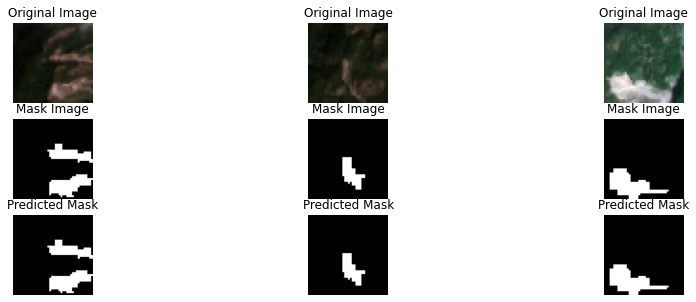

136/136 [==============================] - 19s 138ms/step
IoU: 0.8158580405165038
Dice coefficient: 0.8985933755868513
Accuracy: 0.9670389152106421
Precision: 0.8906757777427251
Recall: 0.9066508431936254
F1 Score: 0.8985923153821437
Overall Accuracy (OA): 1.4603714506445267
Kappa coefficient: 0.8789154964912615


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Activation, multiply, add
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unet_with_attention_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # U-Net with Attention Gate Model
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)

    # Decoder with Attention Gate
    up1 = UpSampling2D(size=(2, 2))(conv4)
    attention1 = attention_gate(conv3, up1)
    merge1 = concatenate([conv3, attention1], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    attention2 = attention_gate(conv2, up2)
    merge2 = concatenate([conv2, attention2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    attention3 = attention_gate(conv1, up3)
    merge3 = concatenate([conv1, attention3], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def attention_gate(up, down):
    up = Conv2D(filters=down.shape[-1], kernel_size=(3, 3), padding='same')(up)
    up = BatchNormalization(axis=3)(up)
    up = Activation('relu')(up)
    up = Conv2D(filters=down.shape[-1], kernel_size=(3, 3), padding='same')(up)
    up = BatchNormalization(axis=3)(up)
    up = Activation('sigmoid')(up)

    return multiply([up, down])

data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的U-Net with Attention Gate模型
unet_input = Input(shape=input_shape, name='unet_input')
unet_output = unet_with_attention_model(input_shape)(unet_input)

combined_output = unet_output
combined_model = Model(inputs=unet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Squeeze and Excitation Blocks (UNetSE)

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
  1/759 [..............................] - ETA: 21:11 - loss: 0.7514 - accuracy: 0.2624

2024-05-17 23:59:09.069283: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


759/759 [==============================] - 41s 51ms/step - loss: 0.2934 - accuracy: 0.8898 - val_loss: 0.2589 - val_accuracy: 0.8971
Epoch 2/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2495 - accuracy: 0.8990 - val_loss: 0.2509 - val_accuracy: 0.8961
Epoch 3/100
759/759 [==============================] - 39s 51ms/step - loss: 0.2411 - accuracy: 0.8997 - val_loss: 0.2422 - val_accuracy: 0.8989
Epoch 4/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2346 - accuracy: 0.9023 - val_loss: 0.2948 - val_accuracy: 0.8749
Epoch 5/100
759/759 [==============================] - 39s 51ms/step - loss: 0.2330 - accuracy: 0.9024 - val_loss: 0.2407 - val_accuracy: 0.8977
Epoch 6/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2277 - accuracy: 0.9041 - val_loss: 0.2360 - val_accuracy: 0.8973
Epoch 7/100
759/759 [==============================] - 38s 50ms/step - loss: 0.2234 - accuracy: 0.9048 - val_loss: 0.2294 - val_accuracy: 0.90

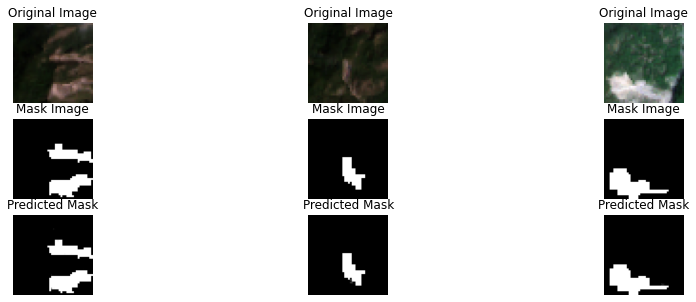

136/136 [==============================] - 14s 101ms/step
IoU: 0.8270250797880165
Dice coefficient: 0.9053247588145098
Accuracy: 0.9693262488550103
Precision: 0.9002086704319127
Recall: 0.9104983568351894
F1 Score: 0.9053242770854282
Overall Accuracy (OA): 1.466568763667822
Kappa coefficient: 0.8870233579717774


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unetse_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # UNet with Squeeze and Excitation Blocks (UNetSE) Model
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # 添加Squeeze and Excitation Block
    squeeze = GlobalAveragePooling2D()(conv9)
    excitation = Dense(64, activation='relu')(squeeze)
    excitation = Dense(64, activation='sigmoid')(excitation)
    excitation = Reshape((1, 1, 64))(excitation)
    conv9 = Multiply()([conv9, excitation])

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 加载数据
data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNetSE模型
input_shape = (256, 256, 3)
unetse_input = Input(shape=input_shape, name='unetse_input')
unetse_output = unetse_model(input_shape)(unetse_input)
combined_model = Model(inputs=unetse_input, outputs=unetse_output)
combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Dilated Convolutions (UNetDC)

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 37s 46ms/step - loss: 0.2670 - accuracy: 0.8883 - val_loss: 0.2280 - val_accuracy: 0.8943
Epoch 2/100
759/759 [==============================] - 33s 44ms/step - loss: 0.2200 - accuracy: 0.8985 - val_loss: 0.2229 - val_accuracy: 0.8936
Epoch 3/100
759/759 [==============================] - 34s 44ms/step - loss: 0.2130 - accuracy: 0.9004 - val_loss: 0.2254 - val_accuracy: 0.8953
Epoch 4/100
759/759 [==============================] - 34s 45ms/step - loss: 0.2114 - accuracy: 0.9010 - val_loss: 0.2163 - val_accuracy: 0.8974
Epoch 5/100
759/759 [==============================] - 33s 44ms/step - loss: 0.2062 - accuracy: 0.9042 - val_loss: 0.2107 - val_accuracy: 0.9014
Epoch 6/100
759/759 [==============================] - 33s 44ms/step - loss: 0.2030 - accuracy: 0.9049 - val_loss: 0.2126 - val_accuracy: 0.9008
Epoch 7/100
759/759 [==============================] - 34s 45ms/step - loss: 0.1985 - accuracy: 0.9085 - val_loss: 0.2076 - val_ac

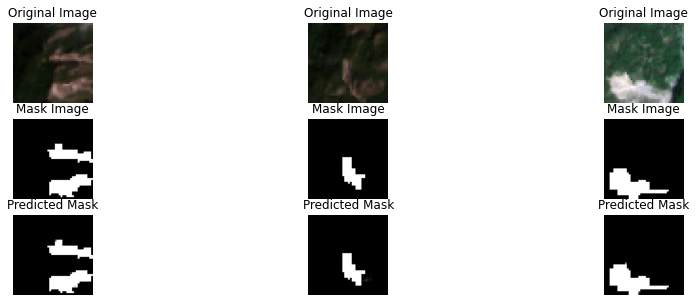

136/136 [==============================] - 14s 101ms/step
IoU: 0.8204893815318426
Dice coefficient: 0.9013929845489742
Accuracy: 0.9687683935783303
Precision: 0.9170703583212376
Recall: 0.8862451682191258
F1 Score: 0.9013943062292905
Overall Accuracy (OA): 1.4275033786765765
Kappa coefficient: 0.88284659457134


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose, Cropping2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unetdc_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # UNet with Dilated Convolutions (UNetDC) Model
    conv1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5)

    up6 = concatenate([Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 加载数据
data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNetDC模型
input_shape = (256, 256, 3)
unetdc_input = Input(shape=input_shape, name='unetdc_input')
unetdc_output = unetdc_model(input_shape)(unetdc_input)
combined_model = Model(inputs=unetdc_input, outputs=unetdc_output)
combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
759/759 [==============================] - 107s 131ms/step - loss: 1.7021 - seg_output_loss: 1.4376 - edge_output_loss: 0.2645 - seg_output_accuracy: 0.8861 - edge_output_accuracy: 0.8883 - val_loss: 1.5436 - val_seg_output_loss: 1.3147 - val_edge_output_loss: 0.2289 - val_seg_output_accuracy: 0.8810 - val_edge_output_accuracy: 0.8929
Epoch 2/100
759/759 [==============================] - 98s 129ms/step - loss: 1.5064 - seg_output_loss: 1.2855 - edge_output_loss: 0.2209 - seg_output_accuracy: 0.8966 - edge_output_accuracy: 0.8995 - val_loss: 1.4734 - val_seg_output_loss: 1.2547 - val_edge_output_loss: 0.2186 - val_seg_output_accuracy: 0.8912 - val_edge_output_accuracy: 0.8979
Epoch 3/100
759/759 [==============================] - 96s 127ms/step - loss: 1.4651 - seg_output_loss: 1.2503 - edge_output_loss: 0.2147 - seg_output_accuracy: 0.8997 - edge_output_accuracy: 0.9020 - val_loss: 1.4539 - val_seg_output_loss: 1.2378 - val_edge_output_loss: 0.2161 - val_seg_output_accurac

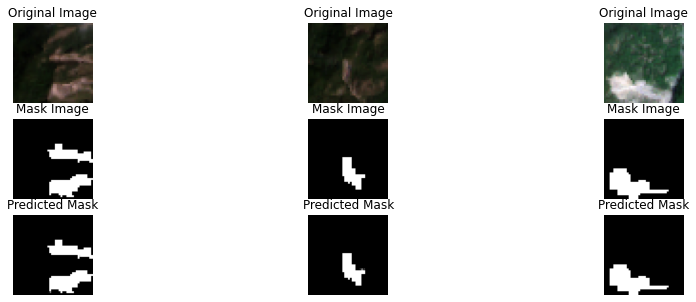

136/136 [==============================] - 28s 205ms/step
IoU: 0.8214499464006372
Dice coefficient: 0.9019729907666987
Accuracy: 0.9683973590761994
Precision: 0.9012945264382507
Recall: 0.9026538377477465
F1 Score: 0.9019736699588177
Overall Accuracy (OA): 14.539333464007017
Kappa coefficient: 0.8831357955198902


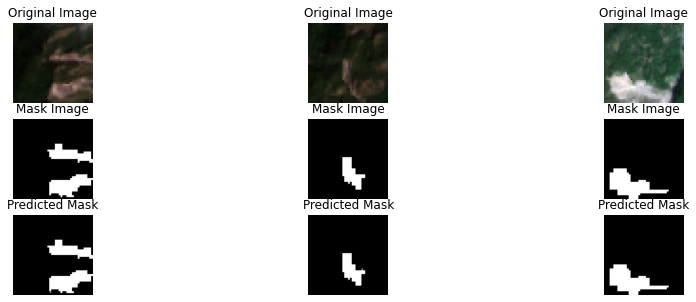

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, LayerNormalization, Dense, MultiHeadAttention, GlobalAveragePooling2D, Add, Reshape, Conv2DTranspose, Activation, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def transformer_block(inputs, num_heads, key_dim):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    ffn_output = tf.keras.Sequential([
        Dense(4 * key_dim, activation='relu'),
        Dense(inputs.shape[-1]),  # 保持与输入的最后一个维度一致
    ])(x)
    x = Add()([x, ffn_output])
    return x

def cbam_block(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    # Channel Attention Module
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    cbam_feature = tf.keras.layers.multiply([input_tensor, cbam_feature])
    
    # Spatial Attention Module
    avg_pool = tf.reduce_mean(cbam_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=3, keepdims=True)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool], axis=3)
    cbam_feature = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    
    cbam_feature = tf.keras.layers.multiply([cbam_feature, input_tensor])
    return cbam_feature

# 新增边界增强损失函数
def boundary_loss(y_true, y_pred):
    # 计算边界增强损失
    boundary_true = tf.image.sobel_edges(y_true)
    boundary_pred = tf.image.sobel_edges(y_pred)
    boundary_loss = tf.reduce_mean(tf.square(boundary_true - boundary_pred))
    return boundary_loss

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def unetplusplus_transformer_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1_1)
    conv1_1 = cbam_block(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2_1)
    conv2_1 = cbam_block(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3_1)
    conv3_1 = cbam_block(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4_1)
    conv4_1 = cbam_block(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5_1)
    conv5_1 = cbam_block(conv5_1)

    # Decoder
    up4_1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_1 = concatenate([up4_1, conv4_1], axis=3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(up4_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)
    conv4_1 = cbam_block(conv4_1)

    up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
    up3_1 = concatenate([up3_1, conv3_1], axis=3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(up3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    conv3_1 = cbam_block(conv3_1)

    up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_1)
    up2_1 = concatenate([up2_1, conv2_1], axis=3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(up2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    conv2_1 = cbam_block(conv2_1)

    up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_1)
    up1_1 = concatenate([up1_1, conv1_1], axis=3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(up1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    conv1_1 = cbam_block(conv1_1)

    # Second Level Nested Skip Connections
    up4_2 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(up4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_2)
    conv4_2 = cbam_block(conv4_2)

    up3_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(up3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_2)
    conv3_2 = cbam_block(conv3_2)

    up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_2)
    up2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(up2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_2)
    conv2_2 = cbam_block(conv2_2)

    up1_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
    up1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(up1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_2)
    conv1_2 = cbam_block(conv1_2)

    # Third Level Nested Skip Connections
    up3_3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_3 = concatenate([up3_3, conv3_2, conv3_1], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(up3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)
    conv3_3 = cbam_block(conv3_3)

    up2_3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_3)
    up2_3 = concatenate([up2_3, conv2_2, conv2_1], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(up2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)
    conv2_3 = cbam_block(conv2_3)

    up1_3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_3)
    up1_3 = concatenate([up1_3, conv1_2, conv1_1], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(up1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    conv1_3 = cbam_block(conv1_3)

    # Transformer Block
    transformer_input = Reshape((conv5_1.shape[1] * conv5_1.shape[2], conv5_1.shape[3]))(conv5_1)
    transformer_output = transformer_block(transformer_input, num_heads=8, key_dim=128)
    transformer_output = Reshape((conv5_1.shape[1], conv5_1.shape[2], conv5_1.shape[3]))(transformer_output)

    # Segmentation Output
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='seg_output')(conv1_3)
    
    # Edge Detection Head
    edge_head = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    edge_head = Conv2D(1, 1, activation='sigmoid', name='edge_output')(edge_head)

    model = Model(inputs=inputs, outputs=[segmentation_output, edge_head])

    # 修改损失函数为复合损失函数
    def composite_loss(y_true, y_pred):
        cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        iou_loss = 1 - iou_coefficient(y_true, y_pred)
        return cross_entropy_loss + dice_loss + iou_loss

    # 结合边界增强损失
    combined_loss = lambda y_true, y_pred: composite_loss(y_true, y_pred) + boundary_loss(y_true, y_pred)

    model.compile(optimizer=Adam(lr=1e-4), 
                  loss={'seg_output': combined_loss, 'edge_output': 'binary_crossentropy'}, 
                  metrics={'seg_output': ['accuracy'], 'edge_output': ['accuracy']})
    return model

def apply_crf(image, prediction):
    # 将预测结果转换为概率分布
    prediction = prediction.squeeze()  # 将 (256, 256, 1) 转换为 (256, 256)
    softmax = np.zeros((2, prediction.shape[0], prediction.shape[1]), dtype=np.float32)
    softmax[0, :, :] = 1 - prediction
    softmax[1, :, :] = prediction

    # 创建CRF模型
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], 2)

    # 将unary能量添加到CRF模型中
    unary = unary_from_softmax(softmax)
    d.setUnaryEnergy(unary)

    # 增加对比度和位置的一对一对特征
    feats = create_pairwise_gaussian(sdims=(3, 3), shape=image.shape[:2])
    d.addPairwiseEnergy(feats, compat=3)

    # 增加颜色特征
    feats = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=image, chdim=2)
    d.addPairwiseEnergy(feats, compat=10)

    # 执行推理
    Q = d.inference(5)

    # 获得最终分割结果
    map = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

    return map

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    seg_preds = preds[0]
    edge_preds = preds[1]
    seg_preds_binary = (seg_preds > 0.5).astype(np.float32)

    # 应用CRF后处理
    crf_preds = np.zeros(seg_preds_binary.shape[:3], dtype=np.float32)
    for i in range(images.shape[0]):
        crf_preds[i] = apply_crf(images[i].astype(np.uint8), seg_preds_binary[i])

    # 确保 masks 和 crf_preds 的形状匹配
    masks = masks.squeeze()  # 将 (770, 256, 256, 1) 转换为 (770, 256, 256)

    # 计算评估指标
    intersection = np.logical_and(masks, crf_preds)
    union = np.logical_or(masks, crf_preds)
    iou = np.sum(intersection) / np.sum(union)

    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(crf_preds))

    accuracy = accuracy_score(masks.flatten(), crf_preds.flatten())

    precision = precision_score(masks.flatten(), crf_preds.flatten())

    recall = recall_score(masks.flatten(), crf_preds.flatten())

    f1 = f1_score(masks.flatten(), crf_preds.flatten())

    oa = (intersection.sum() / masks.size) * 100

    kappa = cohen_kappa_score(masks.flatten(), crf_preds.flatten())

    return iou, dice, accuracy, precision, recall, f1, oa, kappa, crf_preds, edge_preds

# 加载数据
data_path = 'landslide4sence/TrainData_3/landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNet++-Transformer多任务模型
input_shape = (256, 256, 3)
multitask_model = unetplusplus_transformer_model(input_shape)

# 训练模型
multitask_model.fit(images, {'seg_output': masks, 'edge_output': masks}, batch_size=4, epochs=100, validation_split=0.3)

# 可视化结果
predictions = multitask_model.predict(images)
plot_images(images, masks, predictions[0])

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, crf_preds, edge_preds = compute_metrics(multitask_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)

# 可视化结果
plot_images(images, masks, crf_preds)
